In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# We need to join the upper directory in order to access the local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import itertools
import json
import logging

logging.basicConfig(level=logging.ERROR)
logger = logging.getLogger(__name__)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import seaborn as sns
import scipy

from scipy.ndimage import uniform_filter1d
from scipy.io import loadmat, savemat

In [5]:
plt.rcParams['font.family'] = 'Linux Libertine O'
plt.rcParams['font.size'] = 10

In [6]:
from pytdoa.mlat import exact, lls, nlls
from pytdoa.pytdoa import brutefoptim, nonlinoptim, linoptim
from pytdoa.util import generate_heatmap, generate_hyperbola
from pytdoa.geodesy.geodesy import SPEED_OF_LIGHT

In [7]:
# Reading the mat files
with open('comnets_data/gnbPositions.json') as gnb_file:
    data = json.load(gnb_file)

gNBs = np.array([data['gnb0'],data['gnb1'],data['gnb2'],data['gnb3']])

with open('comnets_data/uePositions.json') as ue_file:
    data = json.load(ue_file)

UEs = np.array([data['ue0'],data['ue1'],data['ue2'],data['ue3'],data['ue4'],data['ue5']])
UEs

array([[1.8 , 6.07],
       [1.  , 6.07],
       [1.8 , 9.14],
       [3.28, 2.97],
       [0.58, 2.03],
       [5.28, 7.68]])

## Playing a bit with each of the positions (there are 6 in total)

In [67]:
POSITION = 5
FREQUENCY_MHZ = 40 # MHz
FREQUENCY = FREQUENCY_MHZ * 1e6

In [68]:
toa_measurements = pd.read_csv(f'comnets_data/experiments/exp{POSITION}/{FREQUENCY_MHZ}mhz.csv')
toa_measurements.drop(['Unnamed: 0',], axis=1, inplace=True)
toa_measurements.head(7)

,gNB0,P0,gNB1,P1,gNB2,P2,gNB3,P3
0,0.0,-inf,0.0,-48.5,-2.0,-46.9,-1.0,-48.9
1,0.0,-inf,0.0,-49.1,-2.0,-48.3,-1.0,-46.9
2,0.0,-inf,0.0,-48.4,-1.0,-46.7,-1.0,-49.0
3,0.0,-inf,0.0,-49.0,-2.0,-48.0,-1.0,-47.3
4,0.0,-inf,0.0,-48.8,-2.0,-46.9,-1.0,-48.5
5,0.0,-inf,1.0,-48.3,-1.0,-46.4,-1.0,-48.7
6,0.0,-inf,1.0,-49.2,-1.0,-48.9,-1.0,-46.5


In [69]:
if FREQUENCY_MHZ == 100:
    if POSITION == 4:
        toa_measurements = toa_measurements.drop(['gNB0','P0'], axis=1)

    toa_filt = toa_measurements.loc[~((toa_measurements == float('-inf')).any(axis=1))]
    toa_filt.reset_index(drop=True, inplace=True)

    if POSITION == 1:
        toa_filt = toa_filt.loc[154:] # Only for Position 1

elif FREQUENCY_MHZ == 40:
    if POSITION != 2:
        toa_measurements = toa_measurements.drop(['gNB0','P0'], axis=1)
    else:
        toa_measurements = toa_measurements.drop(['gNB1','P1'], axis=1)

    toa_filt = toa_measurements.loc[~((toa_measurements == float('-inf')).any(axis=1))]
    toa_filt.reset_index(drop=True, inplace=True)

toa_filt

,gNB1,P1,gNB2,P2,gNB3,P3
0,0.0,-48.5,-2.0,-46.9,-1.0,-48.9
1,0.0,-49.1,-2.0,-48.3,-1.0,-46.9
2,0.0,-48.4,-1.0,-46.7,-1.0,-49.0
3,0.0,-49.0,-2.0,-48.0,-1.0,-47.3
4,0.0,-48.8,-2.0,-46.9,-1.0,-48.5
...,...,...,...,...,...,...
2043,1.0,-48.5,-1.0,-46.4,-1.0,-47.8
2044,-1023.0,-49.0,-1.0,-47.4,-1.0,-47.2
2045,1.0,-48.9,-1.0,-47.4,-1.0,-47.0
2046,1.0,-49.1,-1.0,-47.5,-1.0,-47.2


## Offset exploration

Text(0, 0.5, 'Measured ToA (samples)')

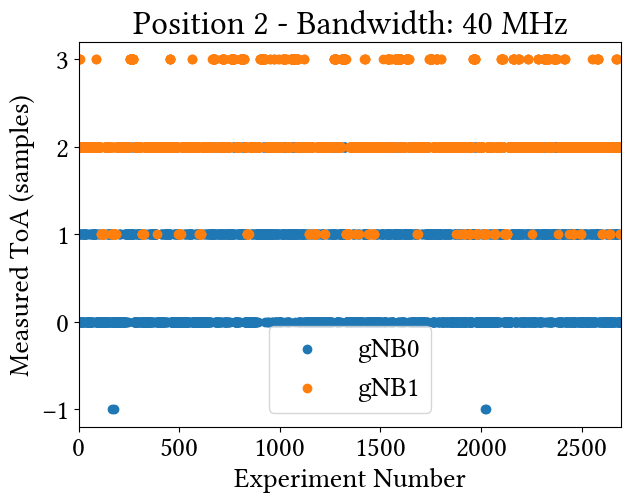

In [54]:
# Let's plot a bit the drift
fig, ax = plt.subplots(figsize=(7, 5))

ax.scatter(x=np.arange(len(toa_filt)), y=toa_filt['gNB0'])
ax.scatter(x=np.arange(len(toa_filt)), y=toa_filt['gNB2'])

ax.legend(['gNB0','gNB1'])

ax.set_xlim([0,len(toa_filt)])

ax.set_title(f'Position {POSITION} - Bandwidth: {FREQUENCY_MHZ} MHz')
ax.set_xlabel('Experiment Number')
ax.set_ylabel('Measured ToA (samples)')

In [33]:
from util import make_grid

/Users/ygglc/Work/PhD/Research/5GLoc/Git/5g-positioning/notebooks/util.py:29: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax[i,j].set_xlim([0,len(toa_filt)])


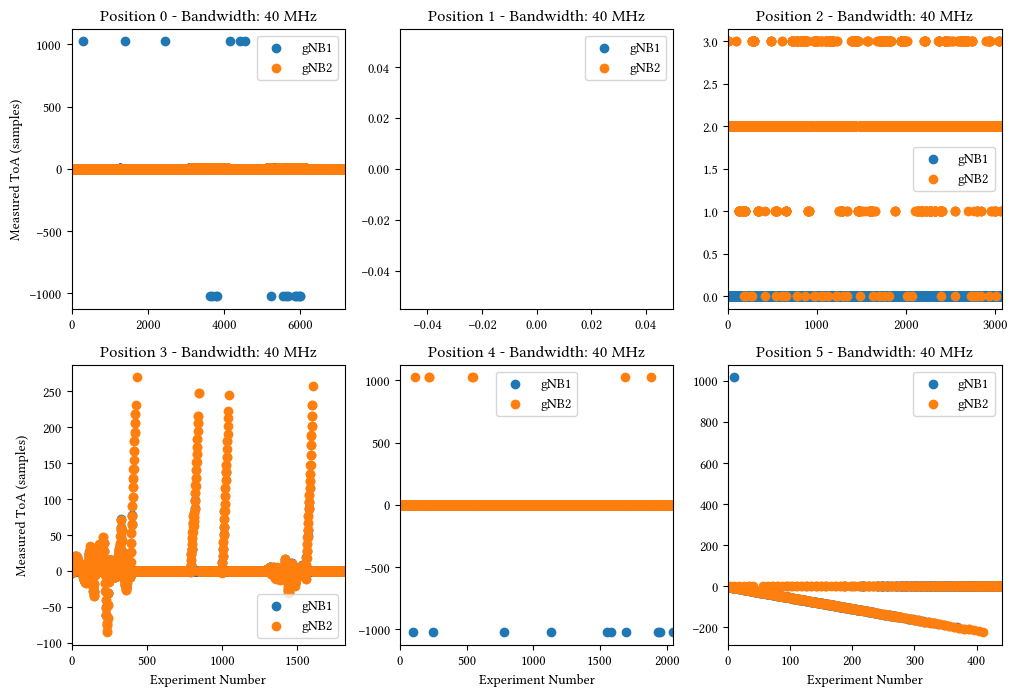

In [35]:
plt.rcParams['font.family'] = 'Linux Libertine O'
plt.rcParams['font.size'] = 10

(fig, ax) = make_grid(40, plot_inf=True)
plt.show()

## Getting some experiments on

In [14]:
# Calculating the theoretical values
theoretical_toa = np.linalg.norm(UEs[POSITION] - gNBs, axis=1)
theoretical_tdoa_mat = theoretical_toa.reshape((-1,1)) - theoretical_toa
theoretical_tdoa = theoretical_tdoa_mat[np.triu_indices(4,k=1)]
theoretical_tdoa

array([ 0.07449244,  0.71944549,  0.6470774 ,  0.64495304,  0.57258496,
       -0.07236809])

In [15]:
EXPERIMENT = 100
FILTER_WINDOW = 1

#
gNB_toas = uniform_filter1d(toa_filt[["gNB0","gNB1","gNB2","gNB3"]].to_numpy(),FILTER_WINDOW,mode='mirror')
gNB_toas_selected = gNB_toas[EXPERIMENT,:]
gNB_tdoas_selected_mat = gNB_toas_selected.reshape((-1,1)) - gNB_toas_selected
selected_tdoa = gNB_tdoas_selected_mat[np.triu_indices(4,k=1)]
selected_tdoa = selected_tdoa / FREQUENCY * SPEED_OF_LIGHT / 1.0000008
selected_tdoa

array([ 2.99792218,  0.        ,  0.        , -2.99792218, -2.99792218,
        0.        ])

In [16]:
linpos = linoptim(gNBs,selected_tdoa[0:4],input_type='xyz').squeeze()
print(f"Calculated Position - x: {linpos[0]:.4f} y: {linpos[1]:.4f}")
print(f"Real Position - x: {UEs[POSITION,0]:.4f} y: {UEs[POSITION,1]:.4f}")

Calculated Position - x: 1.9200 y: 6.4095
Real Position - x: 1.8000 y: 6.0700


In [17]:
combination_range = itertools.combinations(np.arange(len(gNBs)), 2)
combinations = np.fromiter(combination_range, dtype=np.dtype((int,2)))

position_nlls = nonlinoptim(gNBs, selected_tdoa, combinations, num_dim=2, p0=np.mean(gNBs,axis=0), input_type="xyz", method="SLSQP")
position_nlls

array([[1.94593935, 6.66825632]])

## Looping over all values

In [70]:
position_lls = 50*np.ones((len(toa_filt),2))
position_nls = 50*np.ones((len(toa_filt),2))

filter_w = 1
if FREQUENCY_MHZ == 100:
    if POSITION == 4:
        n = 3
        gNB_toas = uniform_filter1d(toa_filt[["gNB1","gNB2","gNB3"]].to_numpy(),filter_w,mode='mirror')
        gNB_loop = gNBs[1:,:]
    else:
        n = 4
        gNB_toas = uniform_filter1d(toa_filt[["gNB0","gNB1","gNB2","gNB3"]].to_numpy(),filter_w,mode='mirror')
        gNB_loop = gNBs
if FREQUENCY_MHZ == 40:
    if POSITION == 2:
        gNB_toas = uniform_filter1d(toa_filt[["gNB0","gNB2","gNB3"]].to_numpy(),filter_w,mode='mirror')
        gNB_loop = gNBs
    else:
        gNB_toas = uniform_filter1d(toa_filt[["gNB1","gNB2","gNB3"]].to_numpy(),filter_w,mode='mirror')
        gNB_loop = gNBs

combination_range = itertools.combinations(np.arange(len(gNB_loop)), 2)
combinations = np.fromiter(combination_range, dtype=np.dtype((int,2)))
for i in range(len(toa_filt)):
        
    gNB_toas_selected = gNB_toas[i,:]
    gNB_tdoas_selected_mat = gNB_toas_selected.reshape((-1,1)) - gNB_toas_selected
    selected_tdoa = gNB_tdoas_selected_mat[np.triu_indices(n,k=1)]
    selected_tdoa = selected_tdoa / FREQUENCY * SPEED_OF_LIGHT

    position_lls[i,:] = linoptim(gNB_loop,selected_tdoa[0:n],input_type='xyz').squeeze()
    position_nls[i,:] = nonlinoptim(gNB_loop, selected_tdoa, combinations, num_dim=2, p0=np.mean(gNB_loop,axis=0), input_type="xyz", method="SLSQP").squeeze()


In [71]:
error_lls = np.linalg.norm((UEs[POSITION,:] - position_lls),axis=1)
error_nls = np.linalg.norm((UEs[POSITION,:] - position_nls),axis=1)

In [72]:
plt.rcParams['font.family'] = 'Linux Libertine O'
plt.rcParams['font.size'] = 20

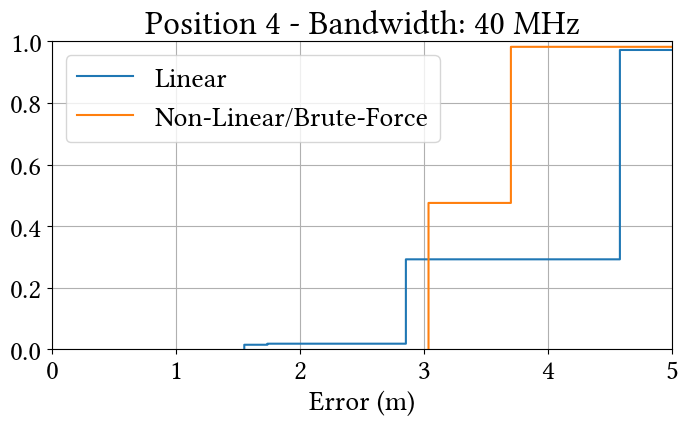

In [73]:
f, ax = plt.subplots(figsize=(8, 4))

ax.ecdf(error_lls)
ax.ecdf(error_nls)

ax.set_xlim([0,5])
ax.grid()

ax.set_title(f'Position {POSITION} - Bandwidth: {FREQUENCY_MHZ} MHz')
ax.set_xlabel('Error (m)')
ax.legend(['Linear', 'Non-Linear/Brute-Force'])